In [122]:
from scipy.io import arff
from operator import index

import numpy as np
from sklearn.neighbors import NearestNeighbors, KernelDensity
from sklearn.metrics import auc,roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.stats import gaussian_kde, multivariate_normal
from scipy import integrate
import seaborn as sns
from sklearn import preprocessing
import math

from statsmodels.sandbox.panel.sandwich_covariance_generic import kernel

plt.rcParams['figure.figsize'] = [15, 7]

In [123]:
arff_file = arff.loadarff('./clusters/artificial/cluto-t4-8k.arff')
df = pd.DataFrame(arff_file[0])

In [124]:
df.head()

,x,y,CLASS
0,68.601997,102.491997,b'0'
1,454.665985,264.808990,b'2'
2,101.283997,169.285995,b'noise'
3,372.614990,263.140991,b'2'
4,300.989014,46.555000,b'5'


In [125]:
X = df.iloc[:,:2].values
y = df.iloc[:,2]
le = LabelEncoder()
y = le.fit_transform(y)

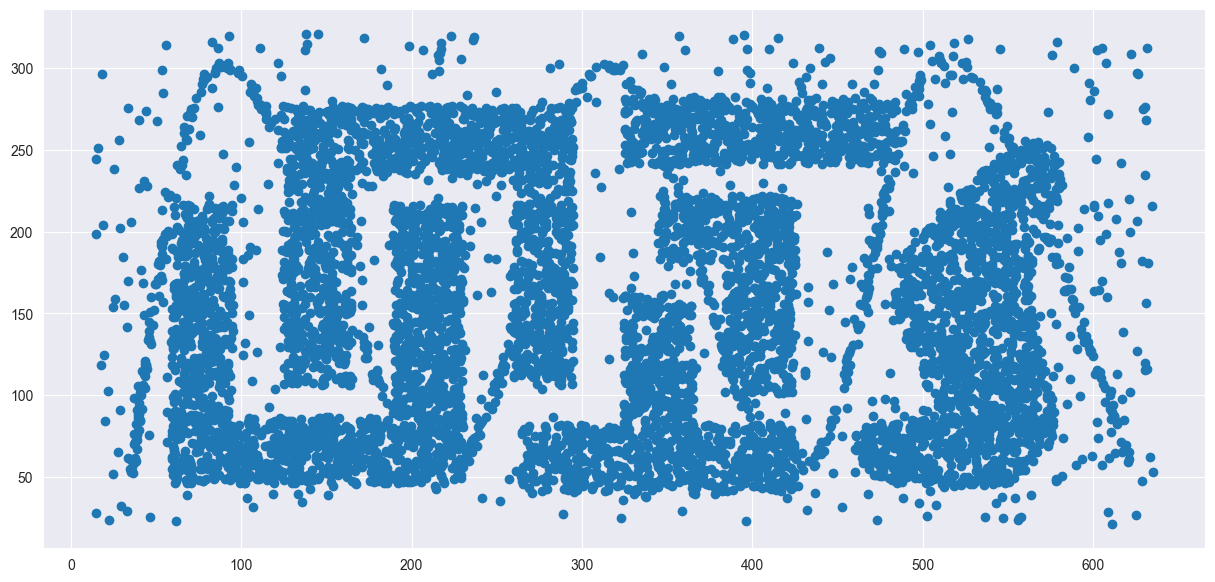

In [126]:
plt.scatter(X[:,0],X[:,1])

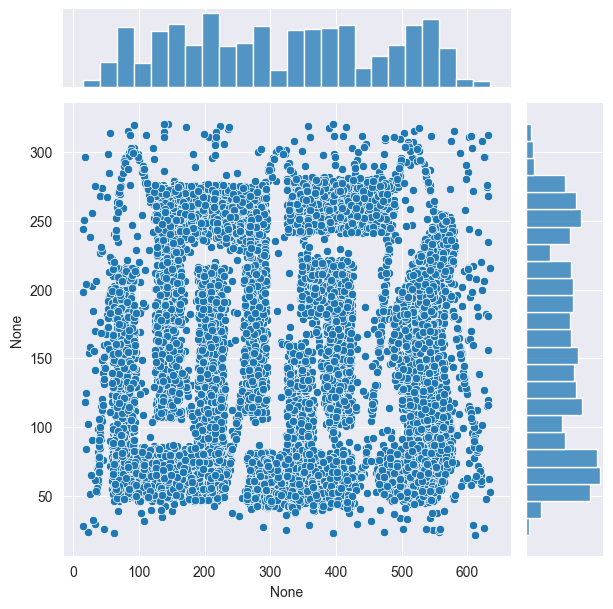

In [127]:
sns.jointplot(x= X[:,0],y=X[:,1],data=df)
plt.show()

In [128]:
def main(X,y,n):
    nn = NearestNeighbors(n_neighbors=n)
    nn.fit(X)
    dist, knn = nn.kneighbors(X)  # returns N index neighbors including self
    return knn, dist

knn, distReturn = main(X,y,2)

In [129]:
def generateArr(newDist, median='median'):
    arr = []
    for x in newDist:  # finds the distance away from that point (index 0)
        if median == 'median':
            arr += [np.median(x)]
        elif median == 'sum': # min + median + max
            arr += [x[1]+np.max(x)+np.median(x)]
        elif median == 'max':
            arr += [np.max(x)]
        elif median == 'minMax':
            arr += [np.max(x)+x[1]]
        elif median == 'medMax':
            arr += [np.median(x)+np.max(x)]
        elif median == 'min':
            arr += [x[1]]
            

    return arr

distReturn = np.array(distReturn)
arr = generateArr(distReturn, median="max")
countOuts = 0
for s in y:
    if s == 6:
        countOuts += 1
print(countOuts)

764


In [130]:
q3 = np.quantile(arr, 0.75)
size = 100
spaced = np.linspace(0,330,num=size)

0.0001174996883615884
1.2452052675226845e-05
7075


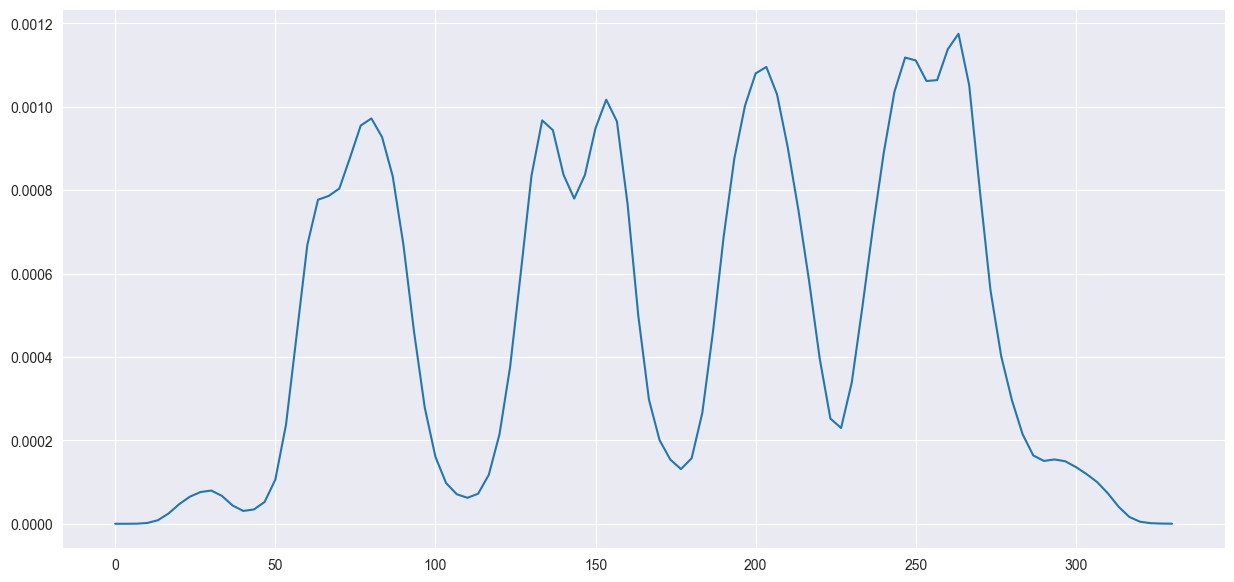

In [131]:
#density function
pdf = np.array([])
totalPdf = []
mean1 = np.mean(X[:,0])
mean2 = np.mean(X[:,1])
sigma = q3*3

for a in range(X.shape[0]):
    for t in spaced:
        w = pow((t-X[a][0]),2)
        q = pow((t-X[a][1]),2)
        expTotal = -((w+q) / (2*pow(sigma,2)))
        e = math.exp(expTotal)
        bottom = (2*math.pi) * (pow(sigma,2))
        bottomR = 1 / bottom
        density = bottomR * e
        pdf = np.append(pdf,density)
    
    pdf = pdf / size
    totalPdf += [list(pdf)]
    pdf = np.array([])

#print(np.sum(totalPdf[625]))
arrToHold = []
kernelAdd = list(map(sum,zip(*totalPdf)))
print(max(kernelAdd)*.1)

sumDen = []
for r in totalPdf:
    sumDen += [np.sum(r)]

print(max(sumDen)*.1)
newOuts = sumDen < max(sumDen)*.01
outliers_new = X[newOuts]
print(len(outliers_new))
plt.plot(spaced,kernelAdd)
plt.show()

4.771992261968471e-06


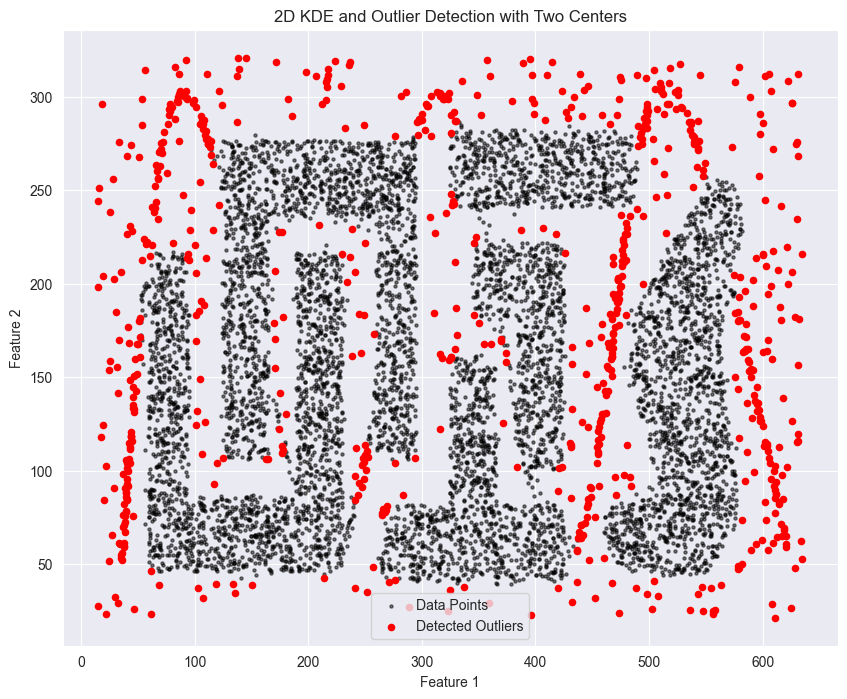

In [132]:
def gaussian_kernel(u):
    # u is the standardized distance between data points and evaluation points
    # d is the number of dimensions (features) of the data
    d = u.shape[1]
    # normalization constant for the Gaussian kernel in d dimensions
    normalization = (2 * np.pi * (pow(q3*3,2))) ** (-1)
    # compute the Gaussian function
    return normalization * np.exp(-0.5 * (np.sum(u**2, axis=1) / (pow(q3*3,2))))

# Multidimensional KDE implementation
def kde_2d(x, data, bandwidth):
    # n: number of data points
    n = data.shape[0]
    # d: dimensionality of the data
    d = x.shape[1]
    # Initialize an array to store the density estimate at each point in x
    estimate = np.zeros(x.shape[0])
    # Loop over each data point to compute its contribution to the density estimate
    for i in range(n):
        # Calculate the standardized distance u using the bandwidth
        u = (x - data[i]) / bandwidth
        # Accumulate the Gaussian kernel contributions from each data point
        estimate += gaussian_kernel(u)
    # Normalize the density estimate by the number of points and the bandwidth raised to the dimensionality
    estimate /= (n * (bandwidth ** d))
    return estimate

# Generate sample data with 2 features and 2 centers
#np.random.seed(42)  # For reproducibility
#data_center1 = np.random.normal(0, 1, (500, 2))
#data_center2 = np.random.normal(5, 1, (500, 2))

# Manually add a few outliers
outliers = np.array([[10, 10], [11, 11], [-3, 10], [7, -5]])
#data = np.vstack((data_center1, data_center2, outliers))
data = X

# Create a grid for KDE evaluation and visualization
x = np.linspace(min(X[:, 0]) - 2, max(X[:, 0]) + 2, 100)
y2 = np.linspace(min(X[:, 1]) - 2, max(X[:, 1]) + 2, 100)
X3, Y = np.meshgrid(x, y2)
xy = np.vstack([X3.ravel(), Y.ravel()]).T

# Compute KDE on the grid
bandwidth = 1.3 # Bandwidth affects the smoothness of the KDE
pdf = kde_2d(xy, data, bandwidth).reshape(X3.shape)
# Detect outliers: points with very low probability density
#threshold = np.mean(pdf)+.000002 # Threshold for density to consider a point an outlier
threshold = np.max(pdf)*.3 
outlier_mask = kde_2d(data, data, bandwidth) < threshold
print(threshold)
detected_outliers = data[outlier_mask]
yOuts = y[outlier_mask]
# Plotting the results
plt.figure(figsize=(10, 8))
#plt.contourf(X, Y, pdf, levels=50, cmap='Blues')  # Density plot
#plt.colorbar(label='Density')
plt.scatter(data[:, 0], data[:, 1], s=5, color='k', alpha=0.5, label='Data Points')  # Data points
plt.scatter(detected_outliers[:, 0], detected_outliers[:, 1], s=20, color='red', label='Detected Outliers')  # Outliers
plt.title('2D KDE and Outlier Detection with Two Centers')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [138]:
affer = 0
for f in yOuts:
    if f == 6:
        affer += 1

print("Positive:" + str(affer),"total"+str(yOuts.shape),"False Positive"+str(affer-yOuts.shape[0]))

Positive:666 total(733,) False Positive-67


[2.02289452e-05 3.06120317e-05 4.62868095e-05 7.08752430e-05
 1.09172502e-04 1.65800749e-04 2.43079178e-04 3.39061863e-04
 4.46982634e-04 5.56789870e-04 6.58234434e-04 7.43942530e-04
 8.10911990e-04 8.59919255e-04 8.93538935e-04 9.13991633e-04
 9.21768799e-04 9.15455458e-04 8.92756611e-04 8.52364480e-04
 7.95876005e-04 7.28737824e-04 6.59549643e-04 5.97944387e-04
 5.52057360e-04 5.26675529e-04 5.22553048e-04 5.36712492e-04
 5.63353191e-04 5.95190119e-04 6.25169053e-04 6.48248658e-04
 6.62550169e-04 6.69204551e-04 6.70921120e-04 6.70193894e-04
 6.68314277e-04 6.65637044e-04 6.62477374e-04 6.59596621e-04
 6.57798703e-04 6.57082376e-04 6.56205957e-04 6.53144388e-04
 6.46187636e-04 6.34965294e-04 6.20776949e-04 6.06099488e-04
 5.93629512e-04 5.85384621e-04 5.82210727e-04 5.83750720e-04
 5.88747576e-04 5.95520807e-04 6.02475675e-04 6.08514399e-04
 6.13224124e-04 6.16737479e-04 6.19227205e-04 6.20163257e-04
 6.17719812e-04 6.08871817e-04 5.90488730e-04 5.61106761e-04
 5.22468820e-04 4.799023

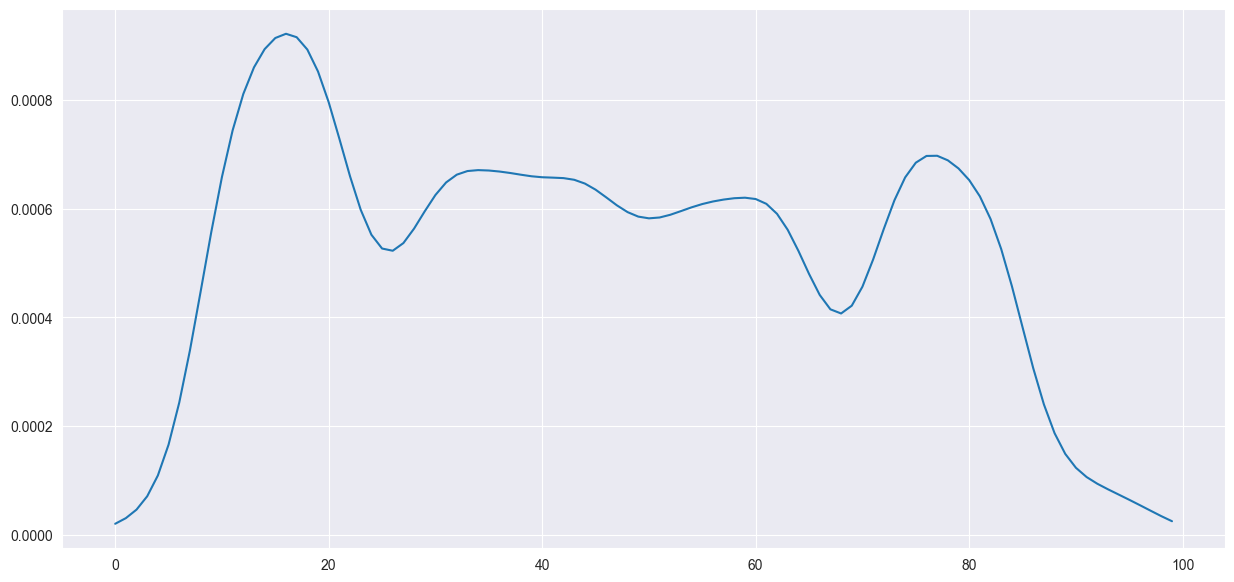

In [134]:
plt.plot(np.sum(pdf,axis=1))
print(np.sum(pdf,axis=1))
#plt.hist(pdf.flatten(), bins=100)
plt.show()

In [135]:
testspace = np.linspace(0,100,100)
newarea = auc(testspace,np.sum(pdf,axis=1))
print(newarea)

0.05212543705307759
